<a href="https://colab.research.google.com/github/PratikStar/google-colab/blob/main/Analysis_of_embeddings_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Owner: pratik-sutar@g.ecc.u-tokyo.ac.jp

**Inputs (Read-only)**

Timbre Embeddings: 
```
content/drive/MyDrive/utokyo/08. research/Music/VAE/ICASSP/timbre-encoder/model/embeddings-2021-10-05-11-08-20.tsv
content/drive/MyDrive/utokyo/08. research/Music/VAE/ICASSP/timbre-encoder/model/embedding-filenames-2021-10-05-11-08-20.tsv
```

Music Embeddings: 
```
content/drive/MyDrive/utokyo/08. research/Music/VAE/ICASSP/music-encoder/model/embeddings-2021-10-04-06-08-29.tsv
content/drive/MyDrive/utokyo/08. research/Music/VAE/ICASSP/music-encoder/model/embedding-filenames-2021-10-04-06-08-29.tsv
```

Trained VAE
```
/content/drive/MyDrive/Music/VAE/ICASSP/timbre-encoder/
```

**Outputs (write)**

Analysis stuff: 
```
content/drive/MyDrive/research/scripts/analysis/
```
And more...


On IST Node

```!pip install matplotlib google.colab```

# Imports & Setup

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import inspect
import math
import json

SHOW_LOGS = True
LOG_LEVEL = 5 # {1-6} High Value -> High verbosity

def log(logline, log_level = 1):
    if SHOW_LOGS and log_level <= LOG_LEVEL:
        stack = inspect.stack()
        the_class = None
        if "self" in stack[1][0].f_locals:
            the_class = stack[1][0].f_locals["self"].__class__.__name__
        the_method = stack[1][0].f_code.co_name
        print("{}.{}: {}".format(the_class, the_method, logline))

# Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Embedding Data loading

### get_segmentid_to_timbre_embedding_dict

In [5]:
# Prerequisite: Drive mounting
#   HARD READS the embeddings from TIMBRE_EMBEDDINGS_PATH, TIMBRE_EMBEDDINGS_FILENAMES_PATH
#   Needs nothing else
TIMBRE_EMBEDDINGS_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/timbre-vae/model/embeddings-2021-10-05-11-08-20.tsv"
TIMBRE_EMBEDDINGS_FILENAMES_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/timbre-vae/model/embedding-filenames-2021-10-05-11-08-20.tsv"

def get_segmentid_to_timbre_embedding_dict(save_flg=True, save_path='/content/dicts'):
    d_segmentid_to_timbre_embedding = {}
    count = 0
    with open(TIMBRE_EMBEDDINGS_FILENAMES_PATH, 'r') as keys, open(TIMBRE_EMBEDDINGS_PATH, 'r') as embeddings:
        while True: 
            count += 1
            embedding = embeddings.readline().strip().split('\t')
            if len(embedding) < 4:
                log("Breaking at line: {}, due to embedding. All OK!".format(count))
                break # the length of embedding should be 4
            embedding = list(map(float, embedding))
            key = keys.readline().split(" ")[0]
            d_segmentid_to_timbre_embedding[key] = embedding
            # if line is empty
            # end of file is reached
            if not key:
                log("Breaking at line: {}, due to keys".format(count))
                break
            # print("{}: {}".format(key.strip(), embedding ))
    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_segmentid_to_timbre_embedding.json'), 'wt') as out:
            json.dump(d_segmentid_to_timbre_embedding, out, sort_keys=True, indent=4)
    return d_segmentid_to_timbre_embedding

d_segmentid_to_timbre_embedding = get_segmentid_to_timbre_embedding_dict(save_flg=False)


None.get_segmentid_to_timbre_embedding_dict: Breaking at line: 10801, due to embedding. All OK!


### get_segmentid_to_music_embedding_dict

In [6]:
# Prerequisite: Drive mounting
#   HARD READS the embeddings from MUSIC_EMBEDDINGS_PATH, MUSIC_EMBEDDINGS_FILENAMES_PATH
#   Needs nothing else
# Music encoding containes DI clip embeddings which is not included in Timbre embeddings
MUSIC_EMBEDDINGS_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/music-vae/model/embeddings-2021-10-04-06-08-29.tsv"
MUSIC_EMBEDDINGS_FILENAMES_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/music-vae/model/embedding-filenames-2021-10-04-06-08-29.tsv"

def get_segmentid_to_music_embedding_dict(save_flg=True, save_path='/content/dicts'):
    d_segmentid_to_music_embedding = {}
    count = 0
    with open(MUSIC_EMBEDDINGS_FILENAMES_PATH, 'r') as keys, open(MUSIC_EMBEDDINGS_PATH, 'r') as embeddings:
        while True: 
            count += 1
            embedding = embeddings.readline().strip().split('\t')
            if len(embedding) < 4:
                log("Breaking at line: {}, due to embedding. All OK!".format(count))
                break # the length of embedding should be 4
            embedding = list(map(float, embedding))

            key = keys.readline().split(" ")[0]

            d_segmentid_to_music_embedding[key] = embedding
            # if line is empty
            # end of file is reached
            if not key:
                log("Breaking at line: {}, due to keys".format(count))
                break
            # print("{}: {}".format(key.strip(), embedding ))
    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_segmentid_to_music_embedding.json'), 'wt') as out:
            json.dump(d_segmentid_to_music_embedding, out, sort_keys=True, indent=4)
    return d_segmentid_to_music_embedding

d_segmentid_to_music_embedding = get_segmentid_to_music_embedding_dict(save_flg=False)


None.get_segmentid_to_music_embedding_dict: Breaking at line: 10936, due to embedding. All OK!


# Playing with Embeddings


## Passage Embeddings 

### get_passageid_to_list_of_segment_embeddings_dict

In [7]:
# Needs, segment to timbre embedding dict. which can be gotten by get_segment_to_timbre_embedding_dict function.
# This function just needs the dict. no file paths etc required.
def get_passageid_to_list_of_segment_embeddings_dict(d_segmentid_to_timbre_embedding, save_flg=True, save_path='/content/dicts'):
    d_passageid_to_list_of_segment_embeddings = {}
    for key, val in d_segmentid_to_timbre_embedding.items():

        # In our embeddings file, we have the "average" embeddings as per the attributes, we are not interested in that
        if re.search("^avg.*", key):
            continue
        passage = key[:8]
        if passage in d_passageid_to_list_of_segment_embeddings:
            d_passageid_to_list_of_segment_embeddings[passage].append(val)
        else:
            d_passageid_to_list_of_segment_embeddings[passage] = [val]
    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_passageid_to_list_of_segment_embeddings.json'), 'wt') as out:
            json.dump(d_passageid_to_list_of_segment_embeddings, out, sort_keys=True, indent=4)
    return d_passageid_to_list_of_segment_embeddings

d_passageid_to_list_of_segment_embeddings = get_passageid_to_list_of_segment_embeddings_dict(d_segmentid_to_timbre_embedding, save_flg=False)

### [calculate - save]\_variance_of_passage_embeddings\_[list - as_csv]

In [8]:
def calculate_variance_of_passage_embeddings_list(d_passageid_to_list_of_segment_embeddings):
    d_var = {}
    for key, val in d_passageid_to_list_of_segment_embeddings.items():
        d_var[key] = np.var(val, axis=0)
    return d_var

d_passageid_to_variance_of_segment_embeddings = calculate_variance_of_passage_embeddings_list(d_passageid_to_list_of_segment_embeddings)

# HARD saves at ANALYSIS_PATH
ANALYSIS_PATH = "/content/drive/Shareddrives/timbre-space-drive/04-analysis"
def save_variance_of_passage_embeddings_as_csv(d_passageid_to_variance_of_segment_embeddings, save_path=ANALYSIS_PATH):
    file_path = os.path.join(save_path, 'variance_of_passage_embeddings.csv')
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["passage", "w-axis", "x-axis", "y-axis", "z-axis"])
        for key, val in d_passageid_to_variance_of_segment_embeddings.items():
            writer.writerow([key] + [str(x) for x in val])

# Uncomment the following line to save as csv
# save_variance_of_passage_embeddings_as_csv(d_passageid_to_variance_of_segment_embeddings)

### [calculate - save]\_mean_of_passage_embeddings\_[list - as_csv]

In [9]:
def calculate_mean_of_passage_embeddings_list(d_passageid_to_list_of_segment_embeddings):
    d_mean = {}
    for key, val in d_passageid_to_list_of_segment_embeddings.items():
        d_mean[key] = np.mean(val, axis=0)

    return d_mean

d_passageid_to_mean_of_segment_embeddings = calculate_mean_of_passage_embeddings_list(d_passageid_to_list_of_segment_embeddings)

# HARD saves at ANALYSIS_PATH
ANALYSIS_PATH = "/content/drive/Shareddrives/timbre-space-drive/04-analysis"
def save_mean_of_passage_embeddings_as_csv(d_passageid_to_mean_of_segment_embeddings, save_path=ANALYSIS_PATH): 
    file_path = os.path.join(save_path, 'mean_of_passage_embeddings.csv')
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["passage", "w-axis", "x-axis", "y-axis", "z-axis"])
        for key,val in d_passageid_to_mean_of_segment_embeddings.items():
            writer.writerow([key] + [str(x) for x in val])

# Uncomment the following line to save as csv
# save_mean_of_passage_embeddings_as_csv(d_passageid_to_mean_of_segment_embeddings)

## Clip Embeddings

### get_clipid_to_list_of_segment_embeddings_dict

In [10]:
# Needs, segment to timbre embedding dict. which can be gotten by get_segment_to_timbre_embedding_dict function.
# This function just needs the dict. no file paths etc required.
def get_clipid_to_list_of_segment_embeddings_dict(d_segmentid_to_timbre_embedding, save_flg=True, save_path='/content/dicts'):
    d_clipid_to_list_of_segment_embeddings = {}
    for key, val in d_segmentid_to_timbre_embedding.items():
        clip = key[:5]
        if clip in d_clipid_to_list_of_segment_embeddings:
            d_clipid_to_list_of_segment_embeddings[clip].append(val)
        else:
            d_clipid_to_list_of_segment_embeddings[clip] = [val]
    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_clipid_to_list_of_segment_embeddings.json'), 'wt') as out:
            json.dump(d_passageid_to_list_of_segment_embeddings, out, sort_keys=True, indent=4)
    return d_clipid_to_list_of_segment_embeddings

d_clipid_to_list_of_segment_embeddings = get_clipid_to_list_of_segment_embeddings_dict(d_segmentid_to_timbre_embedding, save_flg=False)

### [calculate - save]\_variance_of_clip_embeddings\_[list - as_csv]

In [11]:
def calculate_variance_of_clip_embeddings_list(d_clipid_to_list_of_segment_embeddings):
    d_var = {}
    for key, val in d_clipid_to_list_of_segment_embeddings.items():
        d_var[key] = np.var(val, axis=0)

    return d_var

d_clipid_to_variance_of_segment_embeddings = calculate_variance_of_clip_embeddings_list(d_clipid_to_list_of_segment_embeddings)

# HARD saves in ANALYSIS_PATH
ANALYSIS_PATH = "/content/drive/Shareddrives/timbre-space-drive/04-analysis"
def save_variance_of_clip_embeddings_as_csv(d_clipid_to_variance_of_segment_embeddings, save_path=ANALYSIS_PATH):
    file_path = os.path.join(save_path, 'variance_of_clip_embeddings.csv')
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["passage", "w-axis", "x-axis", "y-axis", "z-axis"])
        for key, val in d_clipid_to_variance_of_segment_embeddings.items():
            writer.writerow([key] + [str(x) for x in val])

# save_variance_of_clip_embeddings_as_csv(d_clipid_to_variance_of_segment_embeddings)

### [calculate - save]\_mean_of_clip_embeddings\_[list - as_csv]

In [12]:
def calculate_mean_of_clip_embeddings_list(d_clipid_to_list_of_segment_embeddings):
    d_mean = {}
    for key, val in d_clipid_to_list_of_segment_embeddings.items():
        d_mean[key] = np.mean(val, axis=0)

    return d_mean

d_clipid_to_mean_of_segment_embeddings = calculate_mean_of_clip_embeddings_list(d_clipid_to_list_of_segment_embeddings)

# HARD saves in ANALYSIS_PATH
ANALYSIS_PATH = "/content/drive/Shareddrives/timbre-space-drive/04-analysis"
def save_mean_of_clip_embeddings_as_csv(d_clipid_to_mean_of_segment_embeddings, save_path=ANALYSIS_PATH):
    file_path = os.path.join(save_path, 'mean_of_clip_embeddings.csv')
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["passage", "w-axis", "x-axis", "y-axis", "z-axis"])
        for key,val in d_clipid_to_mean_of_segment_embeddings.items():
            writer.writerow([key] + [str(x) for x in val])

# save_mean_of_clip_embeddings_as_csv(d_clipid_to_mean_of_segment_embeddings)

## visualize_in_2d_any_key_to_embedding_dict

In [13]:
ANALYSIS_PATH = "/content/drive/Shareddrives/timbre-space-drive/04-analysis"
def visualize_in_2d_any_key_to_embedding_dict(d_key_to_embedding, name="Plot", save_path=ANALYSIS_PATH, dpi=120, save_flg=False):
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(20, 10), dpi=dpi)
    fig.suptitle(name)
    axs[0][0].scatter([v[0] for v in d_key_to_embedding.values()], [v[1] for v in d_key_to_embedding.values()], s=10, c='red')
    axs[0][0].set_title('w-x plot')

    axs[0][1].scatter([v[0] for v in d_key_to_embedding.values()], [v[2] for v in d_key_to_embedding.values()], s=10, c='blue')
    axs[0][1].set_title('w-y plot')

    axs[0][2].scatter([v[0] for v in d_key_to_embedding.values()], [v[3] for v in d_key_to_embedding.values()], s=10, c='green')
    axs[0][2].set_title('w-z plot')

    axs[1][0].scatter([v[1] for v in d_key_to_embedding.values()], [v[2] for v in d_key_to_embedding.values()], s=10, c='orange')
    axs[1][0].set_title('x-y plot')

    axs[1][1].scatter([v[1] for v in d_key_to_embedding.values()], [v[3] for v in d_key_to_embedding.values()], s=10, c='cyan')
    axs[1][1].set_title('x-z plot')

    axs[1][2].scatter([v[2] for v in d_key_to_embedding.values()], [v[3] for v in d_key_to_embedding.values()], s=10, c='pink')
    axs[1][2].set_title('y-z plot')

    for label in d_key_to_embedding.keys():
        axs[0][0].annotate(label, (d_key_to_embedding[label][0], d_key_to_embedding[label][1]), fontsize=2)
        axs[0][1].annotate(label, (d_key_to_embedding[label][0], d_key_to_embedding[label][2]), fontsize=2)
        axs[0][2].annotate(label, (d_key_to_embedding[label][0], d_key_to_embedding[label][3]), fontsize=2)
        axs[1][0].annotate(label, (d_key_to_embedding[label][1], d_key_to_embedding[label][2]), fontsize=2)
        axs[1][1].annotate(label, (d_key_to_embedding[label][1], d_key_to_embedding[label][3]), fontsize=2)
        axs[1][2].annotate(label, (d_key_to_embedding[label][2], d_key_to_embedding[label][3]), fontsize=2)
    if save_flg:
        plt.savefig(os.path.join(save_path, name +'.png'))
    plt.show()
    plt.close('all') 
    return fig, axs

# fig, axs = visualize_in_2d_any_key_to_embedding_dict(d_clipid_to_mean_of_segment_embeddings, name="mean of clip embeddings", dpi=120, save_flg=False)
# fig, axs = visualize_in_2d_any_key_to_embedding_dict(d_clipid_to_variance_of_segment_embeddings, name="variance of clip embeddings", dpi=120, save_flg=False)
# fig, axs = visualize_in_2d_any_key_to_embedding_dict(d_passageid_to_mean_of_segment_embeddings, name="mean of passage embeddings", dpi=120, save_flg=False)
# fig, axs = visualize_in_2d_any_key_to_embedding_dict(d_passageid_to_variance_of_segment_embeddings, name="variance of passage embeddings", dpi=120, save_flg=False)

# Playing with Annotations

### Imports & setup

In [14]:
import csv
from datetime import datetime
import pytz
import numpy as np
import json
import os
import os.path
import pandas as pd
import pprint
import json

EXPORTS_DYNAMO_DIRECTORY = "/content/drive/Shareddrives/timbre-space-drive/data/exports-dynamo"
TIMBRE_SURVEY_EXPORT = os.path.join(EXPORTS_DYNAMO_DIRECTORY, '20210905160610-timbre_survey.csv')
# exports_drive_directory = "../exports-drive"

if not os.path.exists("dicts"):
    os.makedirs("dicts")
if not os.path.exists("tsv"):
    os.makedirs("tsv")

### get_attribute_to_count_of_pairwise_annotations

In [15]:
# Returns: { <attribute>: count}
# Interpretation: <attribute> was asked in a pairwise question AND the answer chosen (clip_a/clip_b)
def get_attribute_to_count_of_pairwise_annotations(timbre_survey_export, save_flg=True, save_path="/content/dicts"):
    d_attribute_to_count_of_pairwise_annotations = {}
    with open(timbre_survey_export, 'r', newline='')  as f:
        reader = csv.DictReader(f, delimiter=',')
        for row in reader:
            ## The person has not actually listened. TODO: check when the feature was added and filter the data since that date.
            # if len(row['clicks']) == 0:
            #     print('Unclicked annotation')
            #     continue

            ans = row['answer']
            ## The answer is 'Not Applicable'
            if ans not in ['clip_a', 'clip_b']:
                continue
            attribute = row['attribute']

            if attribute not in d_attribute_to_count_of_pairwise_annotations:
                d_attribute_to_count_of_pairwise_annotations[attribute] = 1
            else:
                d_attribute_to_count_of_pairwise_annotations[attribute] += 1


    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_attribute_to_count_of_pairwise_annotations.json'), 'wt') as out:
            json.dump(d_attribute_to_count_of_pairwise_annotations, out, sort_keys=True, indent=4)
    return d_attribute_to_count_of_pairwise_annotations

d_attribute_to_count_of_pairwise_annotations = get_attribute_to_count_of_pairwise_annotations(TIMBRE_SURVEY_EXPORT, save_flg=True)


### get_attribute_to_pairwise_comparision_result_for_arrow_plot

In [16]:
# Returns: { <attribute>: [[clip_a, clip_b], [..., ...]]}
# Here clip_b is the answer
def get_attribute_to_pairwise_comparision_result_for_arrow_plot(timbre_survey_export, save_flg=True, save_path="/content/dicts"):
    d_attribute_to_pairwise_comparision_result = {} 
    with open(timbre_survey_export, 'r', newline='')  as f:
        reader = csv.DictReader(f, delimiter=',')
        for row in reader:
            ## The person has not actually listened. TODO: check when the feature was added and filter the data since that date.
            # if len(row['clicks']) == 0:
            #     print('Unclicked annotation')
            #     continue

            ans = row['answer']
            ## The answer is 'Not Applicable'
            if ans not in ['clip_a', 'clip_b']:
                continue

            attribute = row['attribute']
            ans_clip = row[ans]
            nonans_clip = row['clip_b' if ans == 'clip_a' else 'clip_a']

            if attribute not in d_attribute_to_pairwise_comparision_result:
                d_attribute_to_pairwise_comparision_result[attribute] = []
            d_attribute_to_pairwise_comparision_result[attribute].append(
                [nonans_clip, ans_clip]
            )


    ## save the dictionary
    if save_flg:
        with open(os.path.join(save_path, 'd_attribute_to_pairwise_comparision_result.json'), 'wt') as out:
            json.dump(d_attribute_to_pairwise_comparision_result, out, sort_keys=True, indent=4)
    return d_attribute_to_pairwise_comparision_result

d_attribute_to_pairwise_comparision_result = get_attribute_to_pairwise_comparision_result_for_arrow_plot(TIMBRE_SURVEY_EXPORT, save_flg=True)


### get_passage_vs_attribute_df

In [17]:
def get_passage_vs_attribute_df(timbre_survey_export, save_flg_passage_to_attribute_to_score=True, save_path="/content/dicts"):
    d = {} ## passage -> attribute
    with open(timbre_survey_export, 'r', newline='')  as f:
        reader = csv.DictReader(f, delimiter=',')
        for row in reader:

            ## The person has not actually listened
            # if len(row['clicks']) == 0:
            #     print('Unclicked annotation')
            #     continue

            ans = row['answer']
            ## TODO. Improve the shabby code
            if ans in ['clip_a', 'clip_b']:
                passage = row[ans]

                attribute = row['attribute']

                if row['clip_a'] not in d:
                    d[row['clip_a']] = {}
                    d[row['clip_a']][attribute] = 1 if ans == 'clip_a' else -1
                else:
                    if attribute not in d[row['clip_a']]:
                        d[row['clip_a']][attribute] = 1 if ans == 'clip_a' else -1
                    else:
                        if ans == 'clip_a':
                            d[row['clip_a']][attribute] += 1
                        else:
                            d[row['clip_a']][attribute] -= 1

                if row['clip_b'] not in d:
                    d[row['clip_b']] = {}
                    d[row['clip_b']][attribute] = 1 if ans == 'clip_b' else -1
                else:
                    if attribute not in d[row['clip_b']]:
                        d[row['clip_b']][attribute] = 1 if ans == 'clip_b' else -1
                    else:
                        if ans == 'clip_b':
                            d[row['clip_b']][attribute] += 1
                        else:
                            d[row['clip_b']][attribute] -= 1

            # Processing "others"
            ## The 'others' string is empty
            ## Note: row['others'] is a string
            if len(row['others']) <= 2:
                continue

            attributes = row['others'][1:-1].replace('\'', '').replace(' ', '').split(',')
            
            for attribute in attributes:
                if passage in d:
                    if attribute in d[passage]:
                        d[passage][attribute] += 1
                    else:
                        d[passage][attribute] = 1
                else:
                    d[passage] = {}
                    d[passage][attribute] = 1

    ## Save the dictionary
    if save_flg_passage_to_attribute_to_score:
        with open(os.path.join(save_path, 'd_passage_to_attribute_to_score.json'), 'wt') as out:
            json.dump(d, out, sort_keys=True, indent=4)

    df = pd.DataFrame.from_dict(data=d)
    df = df.T # transpose the DF. Now, rows -> passages, columns -> attributes
    
    # print(df)
    return df

df = get_passage_vs_attribute_df(TIMBRE_SURVEY_EXPORT, save_flg_passage_to_attribute_to_score=True)
# df

### get_attribute_to_passage_to_score_dict

In [18]:
# Input to this will be clips x attributes dataframe. Using get_passage_vs_attribute_df
def get_attribute_to_passage_to_score_dict(df, save_flg=True, save_path='/content/dicts'):
    d_attribute_to_passage_to_score = {}
    for (attribute, passages) in df.iteritems():
        # print(attribute)
        # print(passages)
        d_attribute_to_passage_to_score[attribute] = {}
        for passage, score in passages.items():
            if pd.notnull(score):
                d_attribute_to_passage_to_score[attribute][passage] = score
                # print(passage)
                # print(score)
    ## Save the dictionary
    with open(os.path.join(save_path, 'd_attribute_to_passage_to_score.json'), 'wt') as out:
        json.dump(d_attribute_to_passage_to_score, out, sort_keys=True, indent=4)
    return d_attribute_to_passage_to_score

d_attribute_to_passage_to_score = get_attribute_to_passage_to_score_dict(df, save_flg=True)

### get_attribute_to_min_and_max_score_points_dict

In [19]:
# Calculates the weighted mean of positive score points and negative score points
def get_attribute_to_min_and_max_score_points_dict(d_attribute_to_passage_to_score, d_passage_to_mean_of_segment_embeddings, save_flg=True, save_path='/content/dicts'):
    d_attribute_to_min_and_max_score_points = {}
    for attribute, d_passage_to_score in d_attribute_to_passage_to_score.items():
        d_neg_passages_to_scores = {passageid: score for passageid, score in d_passage_to_score.items() if score < 0}
        d_pos_passages_to_scores = {passageid: score for passageid, score in d_passage_to_score.items() if score > 0} # excluding 0s

        d_neg_passages_to_embeddings = {passageid: em for passageid, em in d_passage_to_mean_of_segment_embeddings.items() if passageid in d_neg_passages_to_scores.keys()}
        d_pos_passages_to_embeddings = {passageid: em for passageid, em in d_passage_to_mean_of_segment_embeddings.items() if passageid in d_pos_passages_to_scores.keys()}

        # calculating neg average
        neg_embeddings = []
        neg_scores = []
        for passageid in d_neg_passages_to_scores:
            neg_scores.append(abs(d_neg_passages_to_scores[passageid]))
            neg_embeddings.append(d_neg_passages_to_embeddings[passageid])
        # log(neg_embeddings)
        # log(neg_scores)
        if len(neg_embeddings) == 0 or len(neg_scores) == 0:
            log("Skipping the passageid: {}".format(passageid))
            break
        average_neg_embedding = np.average(neg_embeddings, weights=neg_scores, axis=0)
        # log(average_neg_embedding)

        # calculating pos average
        pos_embeddings = []
        pos_scores = []
        for passageid in d_pos_passages_to_scores:
            pos_scores.append(abs(d_pos_passages_to_scores[passageid]))
            pos_embeddings.append(d_pos_passages_to_embeddings[passageid])
        # log(pos_embeddings)
        # log(pos_scores)
        if len(pos_embeddings) == 0 or len(pos_scores) == 0:
            log("Skipping the passageid: {}".format(passageid))
            break
        average_pos_embedding = np.average(pos_embeddings, weights=pos_scores, axis=0)
        # log(average_pos_embedding)

        d_attribute_to_min_and_max_score_points[attribute] = {"min": average_neg_embedding.tolist(), "max": average_pos_embedding.tolist()}
        ## Save the dictionary
        with open(os.path.join(save_path, 'd_attribute_to_min_and_max_score_points.json'), 'wt') as out:
            json.dump(d_attribute_to_min_and_max_score_points, out, sort_keys=True, indent=4)
    return d_attribute_to_min_and_max_score_points

d_attribute_to_min_and_max_score_points = get_attribute_to_min_and_max_score_points_dict(d_attribute_to_passage_to_score, d_passageid_to_mean_of_segment_embeddings, save_flg=True)
# d_attribute_to_min_and_max_score_points

### plot_arrow_plot_from_pairwise_comparision_result

In [20]:
def plot_arrow_plot_from_pairwise_comparision_result(attribute, list_of_a_to_b_clips, filename, d_passageid_to_mean_of_segment_embeddings, dpi=120, visualize_flg=False, save_flg=True, save_path='/content/drive/Shareddrives/timbre-space-drive/04-analysis/visualization/arrow'):
    print(attribute)
    # print(list_of_a_to_b_clips)

    a,b = [],[]
    for pair in list_of_a_to_b_clips:
        a.append(d_passageid_to_mean_of_segment_embeddings[pair[0]])
        b.append(d_passageid_to_mean_of_segment_embeddings[pair[1]])

    flat = [x for row in a+b for x in row]
    neglim = -1 * min(flat) if min(flat) < 0 else min(flat)
    poslim = max(flat)
    lim = max(neglim, poslim)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(20, 10), dpi=dpi)
    fig.suptitle("{}: arrow plot for pairwise annotations results".format(attribute), fontsize='xx-large')
  
    for plot in range(6):
        px = plot // 3
        py = plot % 3
        x = min (px, py)
        y = px + py

        for i in range(len(a)):
            xi = a[i][x]
            xj = a[i][y]
            yi = b[i][x]
            yj = b[i][y]
            # print("For {} {} & {} {}".format(xi, xj, yi, yj))

            axs[px][py].arrow(xi, xj, yi - xi, yj - xj, width = 0.01, head_width=0.1)
            axs[px][py].set_xlim([-1 * lim, lim])
            axs[px][py].set_ylim([-1 * lim, lim])

    if visualize_flg:
        plt.show()
    if save_flg:
        plt.savefig(os.path.join(save_path, filename +'.png'))
    plt.close(fig) 


# Driver: Tested OK! And generated .pngs
# for attribute, pairwise_comparision_result in d_attribute_to_pairwise_comparision_result.items():
#     filename = str(d_attribute_to_count_of_pairwise_annotations[attribute]) + "-" + attribute
#     plot_arrow_plot_from_pairwise_comparision_result(attribute, pairwise_comparision_result, filename, d_passageid_to_mean_of_segment_embeddings, visualize_flg=False, save_flg=True, dpi=300)

# Analysis. The below plots show good results
# Airy Artificial, "Bell-like", "Brilliant", "Brittle", Brutal, buzzy, Clear, Cutting, Dirty, "Distorted"




### plot_negative_vs_positive_passages_by_score_for_given_attribute

In [21]:
def plot_negative_vs_positive_passages_by_score_for_given_attribute(attribute, d_passageid_to_mean_of_segment_embeddings, d_passage_to_score, dpi=120, visualize_flg=False, save_flg=True, save_path='/content/drive/Shareddrives/timbre-space-drive/04-analysis/visualization/pos_neg'):
    print(attribute)
    print("Number of annotations: {} ".format(len(d_passage_to_score)))
    # print({k: v for k, v in sorted(d_passage_to_score.items(), key=lambda item: item[1], reverse=True)})

    neg_passages = [k for k in d_passage_to_score if d_passage_to_score[k] < 0]
    pos_passages = [k for k in d_passage_to_score if d_passage_to_score[k] >= 0]

    neg_embeddings = [em for k, em in d_passageid_to_mean_of_segment_embeddings.items() if k in neg_passages]
    pos_embeddings = [em for k, em in d_passageid_to_mean_of_segment_embeddings.items() if k in pos_passages]

#   print(neg_embeddings)
#   print(pos_embeddings)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(20, 10), dpi=dpi)
    fig.suptitle("\"{}\": negative-score (red) v/s positive-score (blue) Annotations Plot. Anno-count: {}".format(attribute, len(d_passage_to_score)), fontsize='xx-large')

    axs[0][0].scatter([v[0] for v in neg_embeddings], [v[1] for v in neg_embeddings], s=10, c='red')
    axs[0][0].scatter([v[0] for v in pos_embeddings], [v[1] for v in pos_embeddings], s=10, c='blue')
    axs[0][0].set_title('w-x plot')

    axs[0][1].scatter([v[0] for v in neg_embeddings], [v[2] for v in neg_embeddings], s=10, c='red')
    axs[0][1].scatter([v[0] for v in pos_embeddings], [v[2] for v in pos_embeddings], s=10, c='blue')
    axs[0][1].set_title('w-y plot')

    axs[0][2].scatter([v[0] for v in neg_embeddings], [v[3] for v in neg_embeddings], s=10, c='red')
    axs[0][2].scatter([v[0] for v in pos_embeddings], [v[3] for v in pos_embeddings], s=10, c='blue')
    axs[0][2].set_title('w-z plot')

    axs[1][0].scatter([v[1] for v in neg_embeddings], [v[2] for v in neg_embeddings], s=10, c='red')
    axs[1][0].scatter([v[1] for v in pos_embeddings], [v[2] for v in pos_embeddings], s=10, c='blue')
    axs[1][0].set_title('x-y plot')

    axs[1][1].scatter([v[1] for v in neg_embeddings], [v[3] for v in neg_embeddings], s=10, c='red')
    axs[1][1].scatter([v[1] for v in pos_embeddings], [v[3] for v in pos_embeddings], s=10, c='blue')
    axs[1][1].set_title('x-z plot')

    axs[1][2].scatter([v[2] for v in neg_embeddings], [v[3] for v in neg_embeddings], s=10, c='red')
    axs[1][2].scatter([v[2] for v in pos_embeddings], [v[3] for v in pos_embeddings], s=10, c='blue')
    axs[1][2].set_title('y-z plot')

    if visualize_flg:
        plt.show()
    if save_flg:
        plt.savefig(os.path.join(save_path, attribute +'.png'))
    plt.close(fig)

# Driver: Tested OK! And generated .pngs
# for attribute, passage_to_score in d_attribute_to_passage_to_score.items():
#     plot_negative_vs_positive_passages_by_score_for_given_attribute(attribute, d_passageid_to_mean_of_segment_embeddings, passage_to_score, dpi=300, visualize_flg=False, save_flg=True)




### plot_min_vs_max_passages_for_given_attribute (TODO)

In [22]:
import math
def plot_min_vs_max_passages_for_given_attribute(attribute, d_passage_to_mean_of_segment_embeddings, d_passage_to_count, save_path='/content/drive/MyDrive/research/scripts/visualization/min_max'):
    print(attribute)

    min_passage = min(d_passage_to_count, key=d_passage_to_count.get)
    min_value = d_passage_to_count[min_passage]

    max_passage = max(d_passage_to_count, key=d_passage_to_count.get)
    max_value = d_passage_to_count[max_passage]

    pos_passages = [k for k in d_passage_to_count if d_passage_to_count[k] >= 0]

    min_embedding = d_passage_to_mean_of_segment_embeddings[min_passage]
    max_embedding = d_passage_to_mean_of_segment_embeddings[max_passage]

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(20, 10), dpi=120)

    fig.suptitle("\"{}\": min (count={}, color=red) v/s max (count={}, color=blue) Annotation count Plot".format(attribute, str(min_value), str(max_value)), fontsize='xx-large')

    axs[0][0].scatter(min_embedding[0], min_embedding[1], s=10, c='red', label=min_value)
    axs[0][0].scatter(max_embedding[0], max_embedding[1], s=10, c='blue', label=max_value)
    axs[0][0].set_title('w-x plot')

    axs[0][1].scatter(min_embedding[0], min_embedding[2], s=10, c='red', label=min_value)
    axs[0][1].scatter(max_embedding[0], max_embedding[2], s=10, c='blue', label=max_value)
    axs[0][1].set_title('w-y plot')

    axs[0][2].scatter(min_embedding[0], min_embedding[3], s=10, c='red', label=min_value)
    axs[0][2].scatter(max_embedding[0], max_embedding[3], s=10, c='blue', label=max_value)
    axs[0][2].set_title('w-z plot')

    axs[1][0].scatter(min_embedding[1], min_embedding[2], s=10, c='red', label=min_value)
    axs[1][0].scatter(max_embedding[1], max_embedding[2], s=10, c='blue', label=max_value)
    axs[1][0].set_title('x-y plot')

    axs[1][1].scatter(min_embedding[1], min_embedding[3], s=10, c='red', label=min_value)
    axs[1][1].scatter(max_embedding[1], max_embedding[3], s=10, c='blue', label=max_value)
    axs[1][1].set_title('x-z plot')

    axs[1][2].scatter(min_embedding[2], min_embedding[3], s=10, c='red', label=min_value)
    axs[1][2].scatter(max_embedding[2], max_embedding[3], s=10, c='blue', label=max_value)
    axs[1][2].set_title('y-z plot')

    plt.savefig(os.path.join(save_path, attribute +'.png'))
    # plt.show()

# for attribute, passage_to_count in d_attribute_to_passage_to_score.items():
#   plot_min_vs_max_passages_for_given_attribute(attribute, d_passageid_to_mean_of_segment_embeddings, passage_to_count)

# Decoding

## Import Timbre VAE

### downgrade to tf===2.4.0

In [23]:
!pip uninstall --yes tensorflow
!pip install tensorflow==2.4.0

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 394.7 MB 14 kB/s 
     |████████████████████████████████| 2.9 MB 44.5 MB/s 
     |████████████████████████████████| 14.8 MB 59.3 MB/s 
     |████████████████████████████████| 132 kB 79.5 MB/s 
     |████████████████████████████████| 3.8 MB 49.6 MB/s 
     |████████████████████████████████| 462 kB 45.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68718 sha256=522bf404d8188291177d6aa89975f45bbe6a5a441cb644a996aa55105632cad4
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found ex

### Import Timbre VAE

In [32]:
import importlib.util
music_vae_spec = importlib.util.spec_from_file_location("music_vae", "/content/drive/Shareddrives/timbre-space-drive/repos/timbre-space/training/vae/music_vae.py")
timbre_vae_spec = importlib.util.spec_from_file_location("timbre_vae", "/content/drive/Shareddrives/timbre-space-drive/repos/timbre-space/training/vae/timbre_vae.py")
music_vae = importlib.util.module_from_spec(music_vae_spec)
timbre_vae = importlib.util.module_from_spec(timbre_vae_spec)
music_vae_spec.loader.exec_module(music_vae)
timbre_vae_spec.loader.exec_module(timbre_vae)


2.4.0


### Load VAE

In [25]:
TIMBREAE_SAVE_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/timbre-vae"
TIMBREAE_MODEL_PATH = os.path.join(TIMBREAE_SAVE_PATH, "model")

WEIGHTS_FILE = "weights.h5"
LEARNING_RATE = 0.0001

# TODO before running this cell independently
# 1. Update the WEIGHTS_FILE

timbreae = timbre_vae.VAE.load(TIMBREAE_MODEL_PATH, WEIGHTS_FILE)

timbreae.compile(LEARNING_RATE)
timbreae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timbre_input (InputLayer)       [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 256, 64, 128) 1280        timbre_input[0][0]               
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 256, 64, 128) 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 256, 64, 128) 512         encoder_relu_1[0][0]             
____________________________________________________________________________________________

## segmentid -> spectrogram

### decode_to_spectrogram_from_segment_id

In [26]:
import numpy as np
import os
TIMBREAE_SAVE_PATH = "/content/drive/Shareddrives/timbre-space-drive/03-training/vae/icassp-2021/timbre-vae"
TIMBREAE_MODEL_PATH = os.path.join(TIMBREAE_SAVE_PATH, "model")

def decode_to_spectrogram_from_segment_id(d_segmentid_to_music_embedding, d_segmentid_to_timbre_embedding, segment_id):
    music_embedding = d_segmentid_to_music_embedding[segment_id]
    log("Music Embedding: {}".format(music_embedding), 3)
    timbre_embedding = d_segmentid_to_timbre_embedding[segment_id]
    log("Timbre Embedding: {}".format(timbre_embedding), 3)

    embedding = np.append(timbre_embedding, music_embedding)
    log("Total Embedding: {}".format(embedding), 3)

    spectrogram = timbreae.decoder.predict(embedding[np.newaxis,...])
    spectrogram = spectrogram.reshape(spectrogram.shape[1], spectrogram.shape[2])
    log("Decoded Spectrogram shape: {}".format(spectrogram.shape), 3)

    return spectrogram

# segmentid = "00003-09-09"
# decoded_spectrogram = decode_to_spectrogram_from_segment_id(d_segmentid_to_music_embedding, d_segmentid_to_timbre_embedding, segmentid)


None.decode_to_spectrogram_from_segment_id: Music Embedding: [0.9291172, -0.18163778, -2.4426346, 0.6238959, -1.7423666, -0.988111, -1.0344158, -0.2810136, 1.079871, -0.0049089575, -0.8193813, 1.5841339, -0.875786, -1.5637858, -1.1254252, -1.8688203]
None.decode_to_spectrogram_from_segment_id: Timbre Embedding: [-1.5479486, -1.6038208, 3.27815, -1.6120468]
None.decode_to_spectrogram_from_segment_id: Total Embedding: [-1.5479486  -1.6038208   3.27815    -1.6120468   0.9291172  -0.18163778
 -2.4426346   0.6238959  -1.7423666  -0.988111   -1.0344158  -0.2810136
  1.079871   -0.00490896 -0.8193813   1.5841339  -0.875786   -1.5637858
 -1.1254252  -1.8688203 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


None.decode_to_spectrogram_from_segment_id: Decoded Spectrogram shape: (256, 64)


## timbre_embedding -> spectrogram

### decode_to_spectrogram_from_given_timbre_embedding

In [27]:
# This function is useful after moving the timbre embeddings
def decode_to_spectrogram_from_given_timbre_embedding(d_segmentid_to_music_embedding, timbre_embedding, segment_id):
    music_embedding = d_segmentid_to_music_embedding[segment_id]
    log("Music Embedding: {}".format(music_embedding), 3)
    log("Given Timbre Embedding: {}".format(timbre_embedding), 3)

    embedding = np.append(timbre_embedding, music_embedding)
    log("Total Embedding: {}".format(embedding), 3)

    spectrogram = timbreae.decoder.predict(embedding[np.newaxis,...])
    spectrogram = spectrogram.reshape(spectrogram.shape[1], spectrogram.shape[2])
    log("Decoded Spectrogram shape: {}".format(spectrogram.shape), 3)

    return spectrogram

# decoded_spectrogram = decode_to_spectrogram_from_given_timbre_embedding(d_segmentid_to_music_embedding, moved_timbre_embedding, "00003-09-09")

# Audio reconstruction

### segment reconstruction helpers

In [88]:
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re 
import pickle

# for segment
def get_original_spectrogram_from_path(spectrogram_path, segmentid):
    original_spectrogram = None
    for filename in os.listdir(spectrogram_path):
        if re.match("^" + segmentid + ".*\.npy$", filename):
            log("Original spectrogram file : {}".format(filename), 3)
            original_spectrogram = np.load(os.path.join(spectrogram_path, filename))
            log("Shape of og spectrogram: {}".format(original_spectrogram.shape), 3)
    if original_spectrogram is None:
        exit("Original file not found! Exiting")
    return original_spectrogram

# Spectrogram -> Audio
def convert_segment_spectrogram_to_audio_signal(spectrogram, segmentid, save_flg=True, filename="reconstructed-audio", save_path='/content/audio'):
    log("segmentid: {}".format(segmentid), 3)
    log("shape of spectrogram: {}".format(spectrogram.shape), 3)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # Denormalize
    with open(os.path.join(MIN_MAX_VALUES_SAVE_DIR, MIN_MAX_VALUES_FILE_NAME), 'rb') as f:
        min_max_values = pickle.load(f)
    min_value, max_value = None, None

    for key, val in min_max_values.items():
        if re.match("^" + segmentid + ".*", key):
            min_value = val["min"]
            max_value = val["max"]
            log("Min: {}, Max: {}".format(str(min_value), str(max_value)), 3)
    if not min_value or not max_value:
        log("Min Max values not found for {}. Returning!".format(segmentid))
        return
    
    denormalized_db_spectrogram = spectrogram * (max_value - min_value) + min_value
    log("shape of denormalized db spectrogram: {}".format(denormalized_db_spectrogram.shape), 3)

    # db_to_amplitude
    inverted_magnitude_spectrogram = librosa.db_to_amplitude(denormalized_db_spectrogram)
    log("shape after db_to_amplitude: {}".format(inverted_magnitude_spectrogram.shape), 3)

    # griffinlim
    reconstructed_segment = librosa.griffinlim(inverted_magnitude_spectrogram, hop_length=HOP_LENGTH)
    log("shape after griffinlim: {}".format(reconstructed_segment.shape), 3)

    if save_flg:
        file_path = os.path.join(save_path, filename + ".wav")
        log("saving to: {}".format(file_path))
        sf.write(file_path, reconstructed_segment, SAMPLE_RATE)
    
    return reconstructed_segment


# Spectrogram -> Image
def convert_spectrogram_to_spectrogramimg(spectrogram, filename, visualize_flg=False, save_flg=True, save_path="/content/"):
    log("Shape of spectrogram img: {}".format(spectrogram.shape))
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.ioff()
    fig, ax = plt.subplots(dpi=120)
    img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax)

    ax.set_title(filename)
    fig.colorbar(img, ax=ax, format="%+2.2f dB")
    if save_flg:
        fig.savefig(os.path.join(save_path, filename + ".png"))  
    if visualize_flg:
        plt.show()
    plt.close(fig)

def remove_ampid_from_spectrogram(spectrogram):
    return spectrogram[:, 1:]

def get_differential_spectrogram(spectrogram_a, spectrogram_b, filename="differential_spectrogram",visualize_flg=False, save_flg=True, save_path="/content/"):
    if spectrogram_a.shape != spectrogram_b.shape:
        log("Shapes of the spectrogram differ. Cannot calculate the differential")
        return None
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    diff_spectrogram = np.abs(spectrogram_b - spectrogram_a)
    plt.ioff()  
    fig, ax = plt.subplots(dpi=120)
    img = librosa.display.specshow(diff_spectrogram, y_axis='log', x_axis='time', ax=ax)

    ax.set_title(filename)
    fig.colorbar(img, ax=ax, format="%+2.2f dB")
    if save_flg:
        fig.savefig(os.path.join(save_path, filename + ".png"))  
    if visualize_flg:
        plt.show()
    plt.close(fig)
    return diff_spectrogram


### passage reconstruction helpers

In [51]:
# Null Spectrograms: <passage-segment>
# 01-12
# 04-10
# 06-00
# 07-10
# 08-13
# 11-08
# 12-14

def decode_and_construct_passage(passageid, save_flg=True, filename="reconstructed-passage", save_path="/content"):
    # passageid to segmentids
    segmentids = sorted([key for key in d_segmentid_to_music_embedding.keys() if key.startswith(passageid)])
    log("segmentids in passage: {}".format(segmentids), 2)

    passage_signal = np.array([])
    for segmentid in segmentids:
        # get spectrograms of segmentid
        spectrogram = decode_to_spectrogram_from_segment_id(d_segmentid_to_music_embedding, d_segmentid_to_timbre_embedding, segmentid)

        # griffinlim on spectrogram
        reconstructed_signal = convert_segment_spectrogram_to_audio_signal(spectrogram[:,1:], segmentid, save_flg=False)

        # append to passage signal
        passage_signal = np.append(passage_signal, reconstructed_signal)
        # print(spectrogram)

    if save_flg:
        file_path = os.path.join(save_path, filename + ".wav")
        log("saving to: {}".format(file_path))
        sf.write(file_path, passage_signal, SAMPLE_RATE)

# **Segment decoding and reconstruction Pipeline**

None.convert_segment_spectrogram_to_audio_signal: saving to: /content/original-00003-07-04.wav
None.convert_segment_spectrogram_to_audio_signal: saving to: /content/reconstructed-00003-07-04.wav
None.convert_spectrogram_to_spectrogramimg: Shape of spectrogram img: (256, 63)


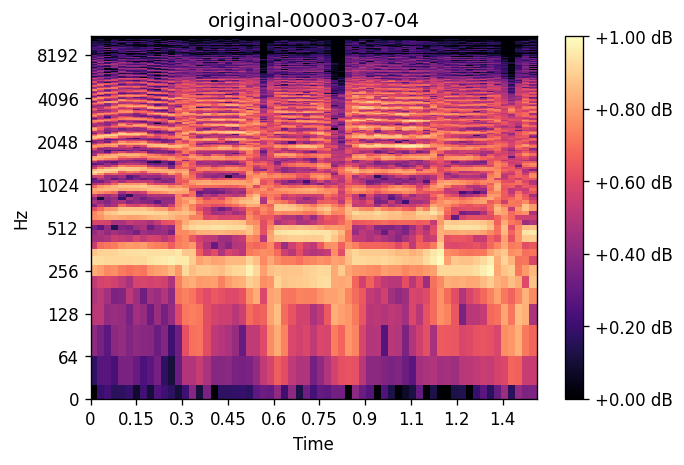

None.convert_spectrogram_to_spectrogramimg: Shape of spectrogram img: (256, 63)


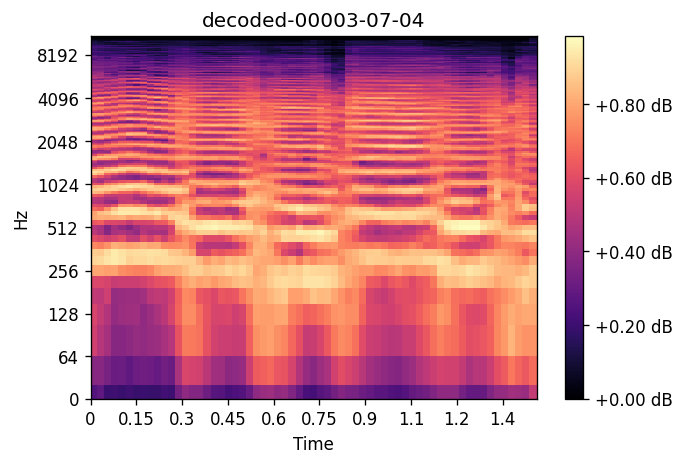

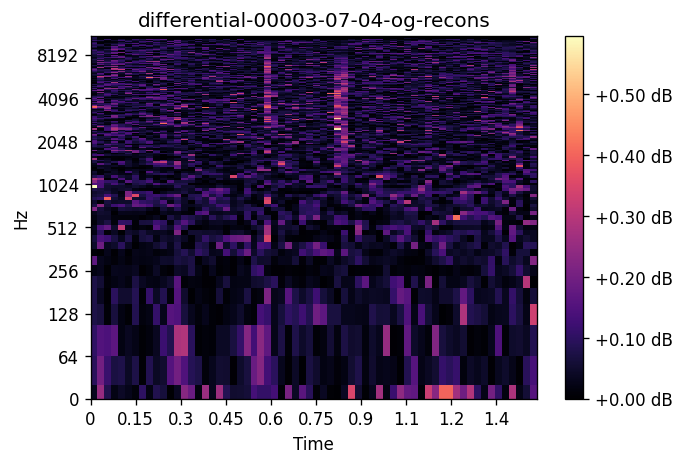

In [50]:
## Driver code: Audio reconstruction for segments

# Config. PLEASE SET THE SEGMENTID
segmentid = "00003-07-04"

# Other Config
SAMPLE_RATE = 22050 # known
FRAME_SIZE = 512 # known
HOP_LENGTH = FRAME_SIZE // 2 # known
SPECTROGRAMS_PATH = "/content/drive/Shareddrives/timbre-space-drive/02-spectrograms-data/spectrogram-2022"
MIN_MAX_VALUES_SAVE_DIR = SPECTROGRAMS_PATH
MIN_MAX_VALUES_FILE_NAME = "min_max_values.pkl"

# 1. segment id -> spectrogram
decoded_spectrogram = decode_to_spectrogram_from_segment_id(d_segmentid_to_music_embedding, d_segmentid_to_timbre_embedding, segmentid)

# 2. spectrogram -> audio
#   just for comparision
original_spectrogram = get_original_spectrogram_from_path(SPECTROGRAMS_PATH, segmentid)

convert_segment_spectrogram_to_audio_signal(original_spectrogram, segmentid, save_flg=True, filename="original-" + segmentid , save_path="/content/")
convert_segment_spectrogram_to_audio_signal(decoded_spectrogram, segmentid, save_flg=True, filename="reconstructed-" + segmentid, save_path="/content/")

# 3. spectrogram -> image
convert_spectrogram_to_spectrogramimg(
    remove_ampid_from_spectrogram(original_spectrogram), 
    "original-" + segmentid, visualize_flg=True, save_flg=True, save_path="/content")
convert_spectrogram_to_spectrogramimg(
    remove_ampid_from_spectrogram(decoded_spectrogram), 
    "decoded-" + segmentid, visualize_flg=True, save_flg=True, save_path="/content")

# 4. differential spectrogram
differential_spectrogram = get_differential_spectrogram(decoded_spectrogram, original_spectrogram, 
                                                        filename="differential-" + segmentid + "-og-recons", 
                                                        visualize_flg=True, save_flg=True, save_path="/content")


# **Passage decoding and reconstruction Pipeline**

In [54]:
passageid = "00003-09"
LOG_LEVEL = 1
# Null Spectrograms: <passage-segment>
# 01-12
# 04-10
# 06-00
# 07-10
# 08-13
# 11-08
# 12-14
decode_and_construct_passage(passageid, save_flg=True, filename="reconstructed-" + passageid, save_path="/content")

None.decode_and_construct_passage: saving to: /content/reconstructed-00003-09.wav.wav


# Moving the points

## Helpers

In [30]:
import numpy as np

def move_point_in_direction_of_vector(point, vector, units_to_move):
    v_hat = vector / np.linalg.norm(vector)
    res = point + v_hat * units_to_move
    return res

## **Moving the segments Pipeline**

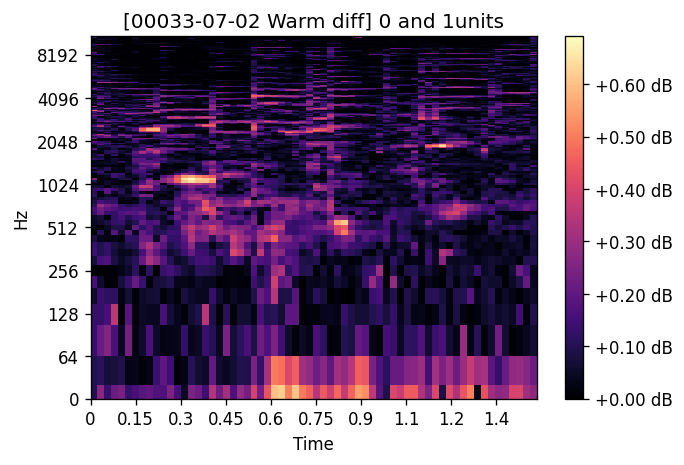

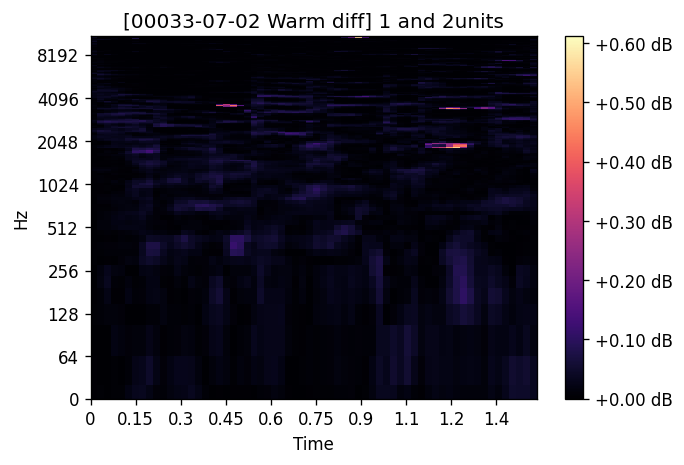

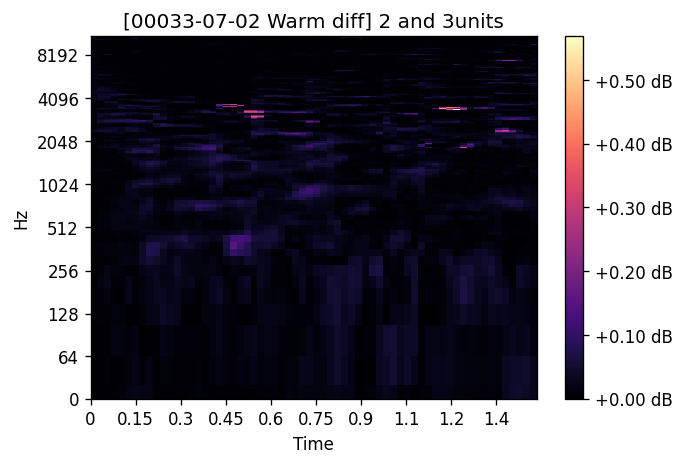

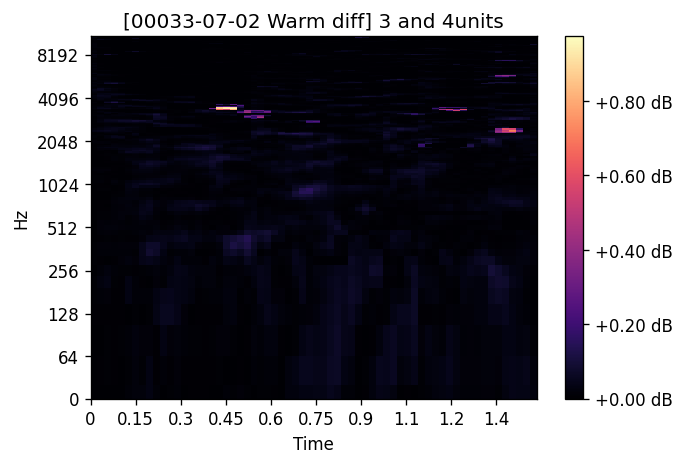

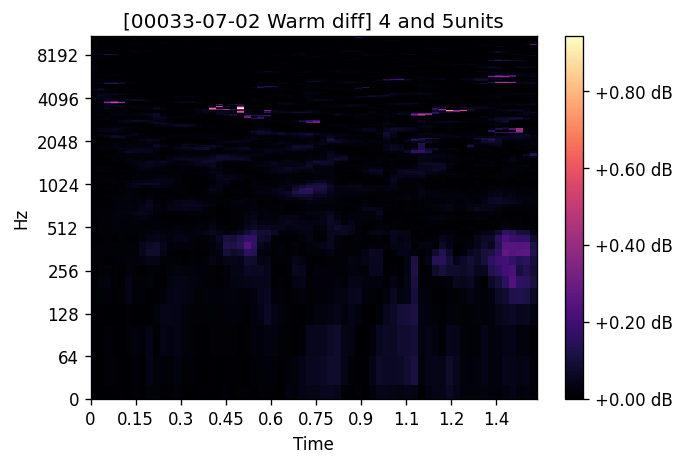

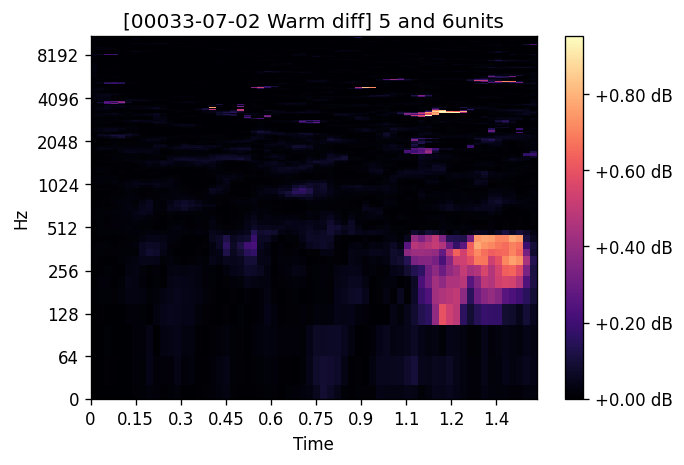

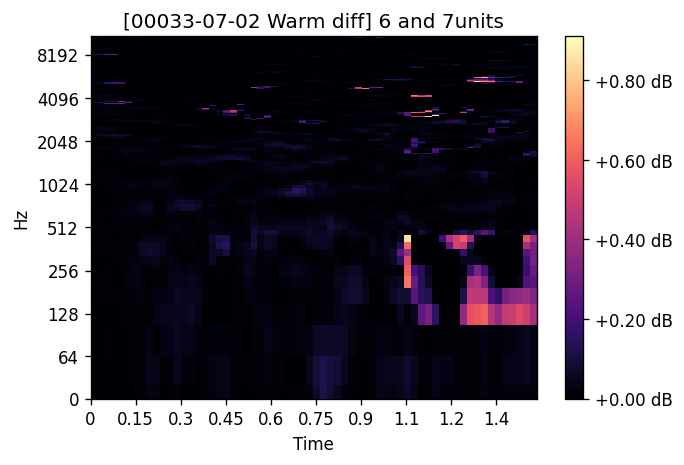

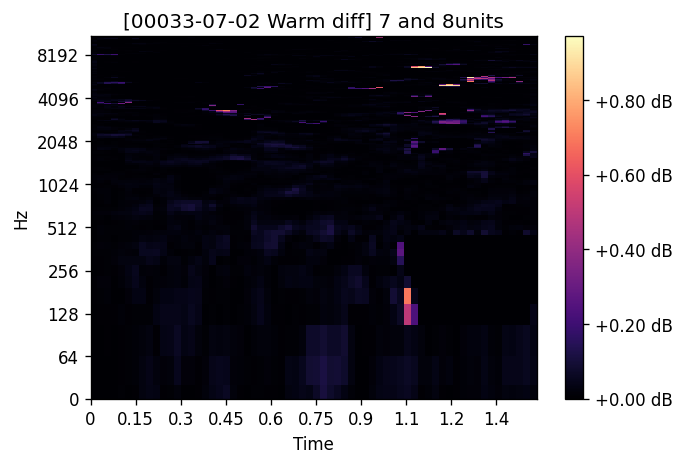

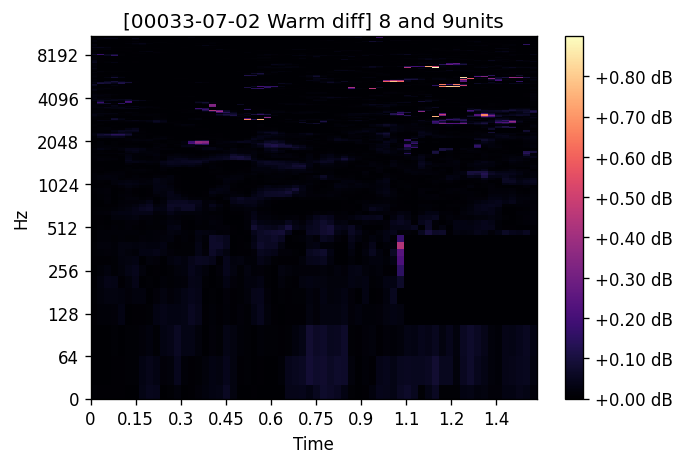

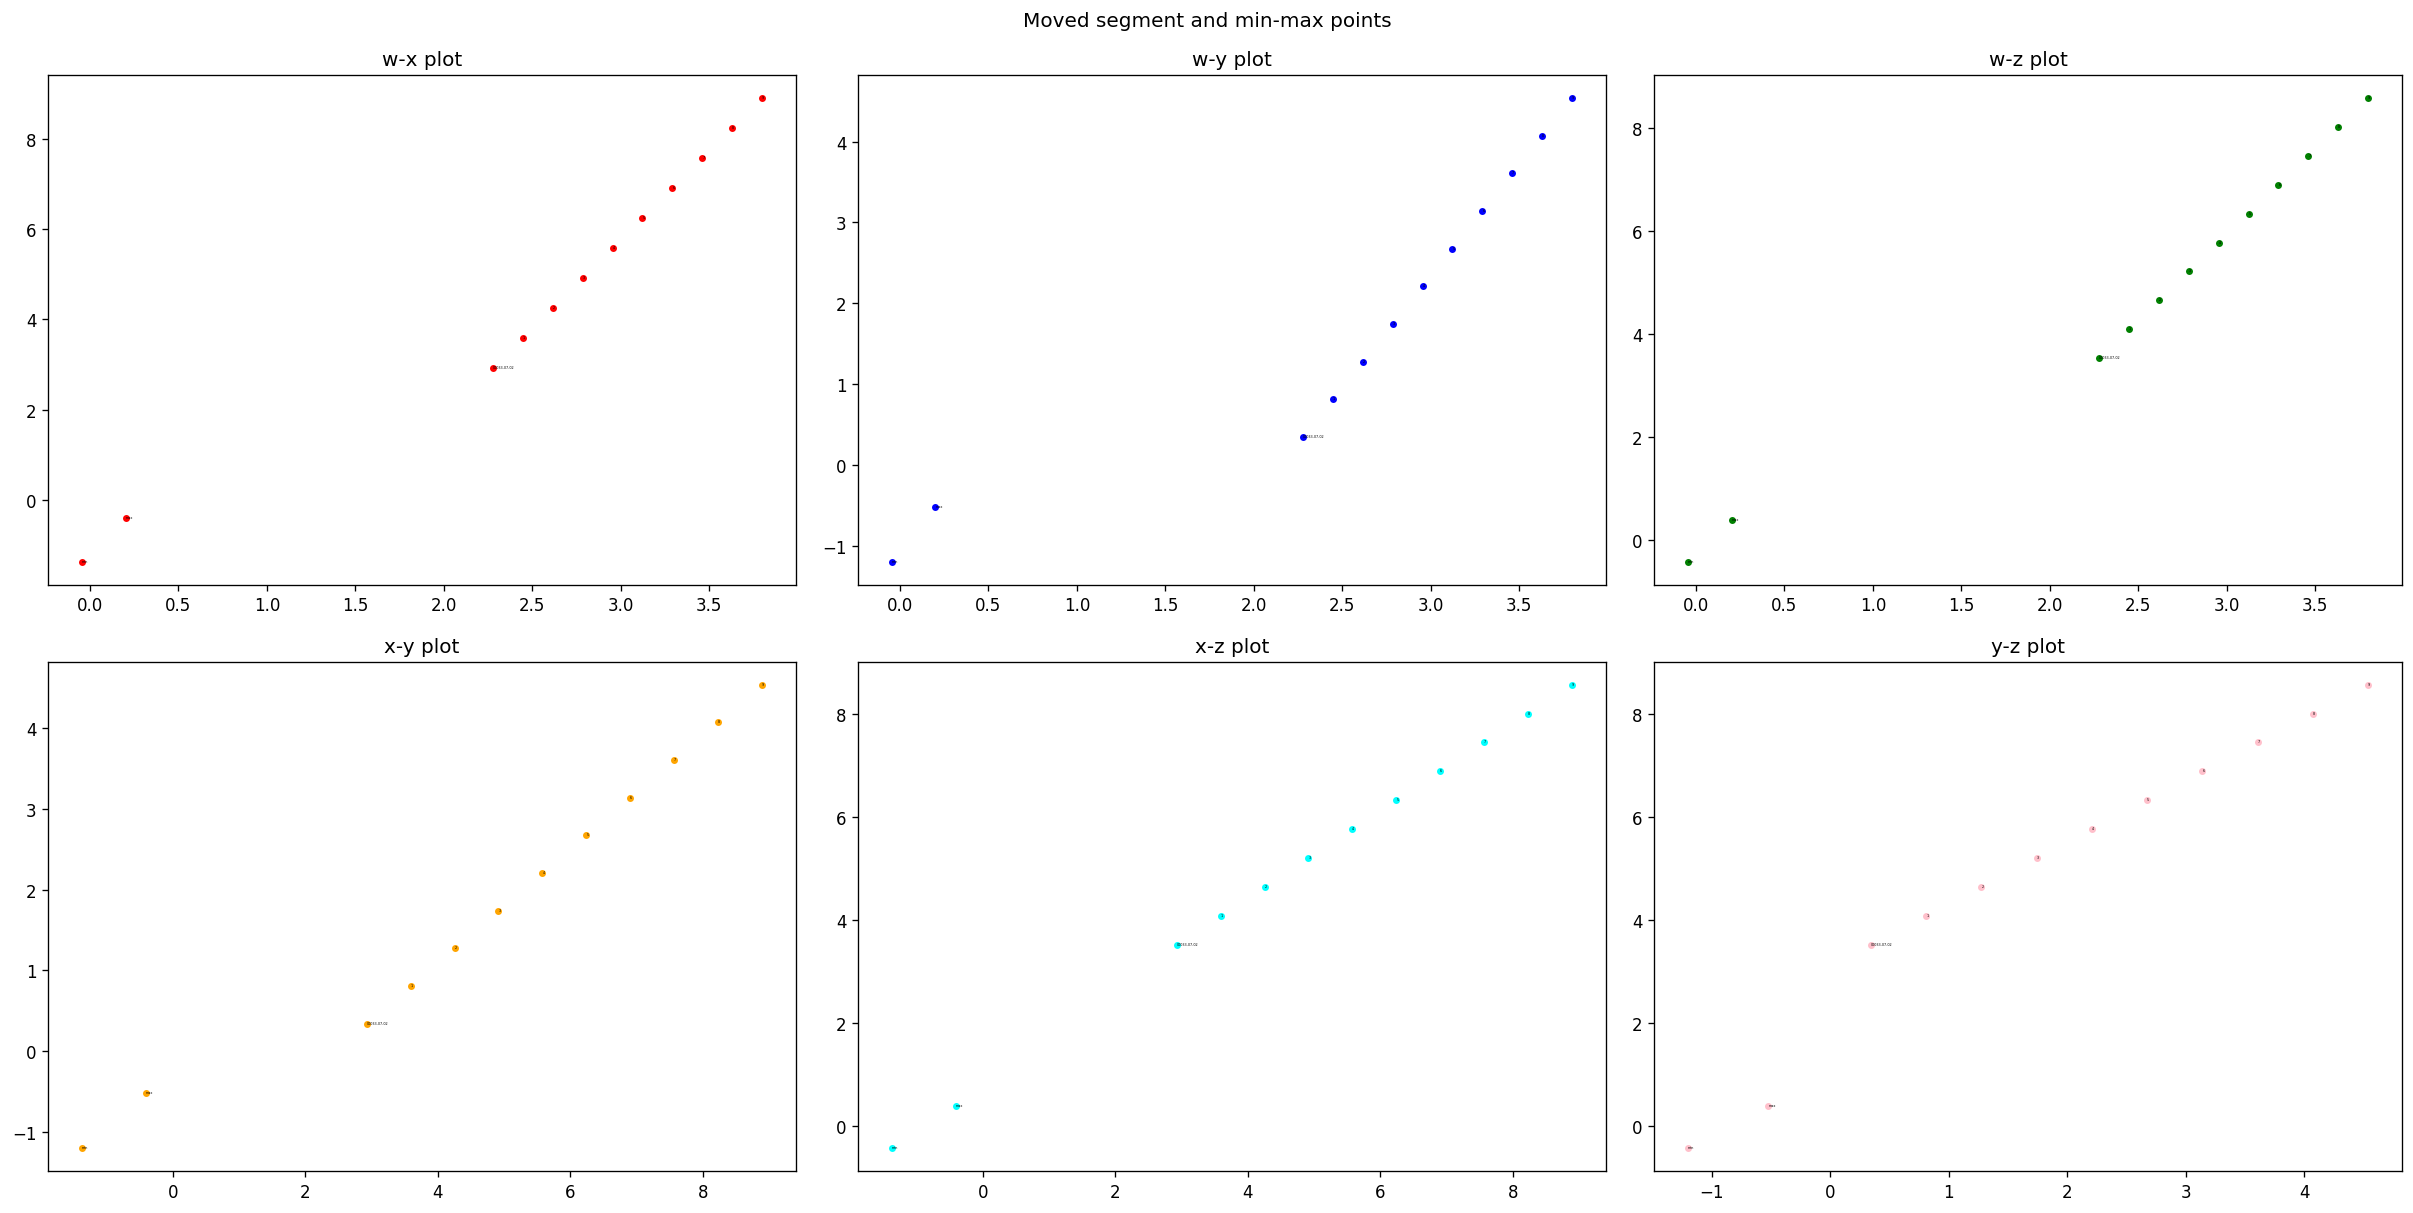

(<Figure size 2400x1200 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34dadee890>,
       dtype=object))

In [101]:
###### PLEASE SET THE FOLLOWING PARAMS ######
SHOW_LOGS=False
segmentid = "00033-07-02"
attribute = "Warm"
range_of_units_to_move = range(1,10,1)

save_reconstructed_audio = True

visualize_moved_spectrogram = False
save_moved_spectrogram = True

visualize_og_to_moved_diff_spectrogram = False
save_og_to_moved_diff_spectrogram = True

visualize_prev_to_new_moved_diff_spectrogram = True
save_prev_to_new_moved_diff_spectrogram = True
#############################################

# Static Config Here#####
#############################################


# get segment embedding
segment_embedding = d_segmentid_to_timbre_embedding[segmentid]
log("OG Segment embedding: {}".format(segment_embedding))

# get original embedding for comparision
original_spectrogram = get_original_spectrogram_from_path(SPECTROGRAMS_PATH, segmentid)

# get attribute and min-max
attribute_min_point = np.array(d_attribute_to_min_and_max_score_points[attribute]['min'])
attribute_max_point = np.array(d_attribute_to_min_and_max_score_points[attribute]['max'])
log("Attribute min point: {}".format(attribute_min_point))
log("Attribute max point: {}".format(attribute_max_point))

# distance between min-max
distance_min_max_points = np.linalg.norm(attribute_max_point - attribute_min_point, ord=2)
log("Distance between min max points: {}".format(distance_min_max_points), log_level=1)
vector_min_to_max = attribute_max_point - attribute_min_point

# For plotting the points
d_moved_points_by_units = {segmentid: segment_embedding, **d_attribute_to_min_and_max_score_points[attribute]}

prev_spectrogram = original_spectrogram
prev_units_moved = 0
number_of_spectrograms = len(range_of_units_to_move)
for units_to_move in range_of_units_to_move:
    # Move the timbre embeddings
    moved_timbre_embedding = move_point_in_direction_of_vector(segment_embedding, vector_min_to_max, units_to_move)
    log("{} units_moved: {}".format(units_to_move, moved_timbre_embedding))
    d_moved_points_by_units[str(units_to_move)] = moved_timbre_embedding

    # Decode to spectrograms
    moved_decoded_spectrogram = decode_to_spectrogram_from_given_timbre_embedding(d_segmentid_to_music_embedding, moved_timbre_embedding, segmentid)

    # Spectrogram to audio
    moved_audio_segments_save_path = os.path.join("/content/drive/Shareddrives/timbre-space-drive/04-analysis/moving/segments/", segmentid, attribute, "audio")
    filename = "[" + segmentid + " " + attribute + " moved] " + str(units_to_move) + " units"
    convert_segment_spectrogram_to_audio_signal(moved_decoded_spectrogram, segmentid, save_flg=save_reconstructed_audio, filename=filename,
                                                save_path=moved_audio_segments_save_path)
    # spectrogram -> spectrogramimg
    moved_spectrogramimg_save_path = os.path.join("/content/drive/Shareddrives/timbre-space-drive/04-analysis/moving/segments/", segmentid, attribute)
    convert_spectrogram_to_spectrogramimg(
        remove_ampid_from_spectrogram(moved_decoded_spectrogram), filename=filename, 
        visualize_flg=visualize_moved_spectrogram, save_flg=save_moved_spectrogram,
        save_path=moved_spectrogramimg_save_path)
    
    # OG-moved differential spectrogram imgs
    og_spectrogramimg_diff_save_path = os.path.join(moved_spectrogramimg_save_path, "diff-with-original")
    og_diff_filename = "[" + segmentid + " " + attribute + " diff] OG and " + str(units_to_move) + "units"
    og_to_moved_diff_spectrogram = get_differential_spectrogram(moved_decoded_spectrogram, original_spectrogram, 
                                                        filename=og_diff_filename, 
                                                        visualize_flg=visualize_og_to_moved_diff_spectrogram, 
                                                        save_flg=save_og_to_moved_diff_spectrogram, save_path=og_spectrogramimg_diff_save_path)
    # prev-moved differential spectrogram imgs
    prev_spectrogramimg_diff_save_path = os.path.join(moved_spectrogramimg_save_path, "diff-with-previous")
    diff_filename = "[" + segmentid + " " + attribute + " diff] " + str(prev_units_moved)+" and " + str(units_to_move) + "units"
    prev_to_new_moved_diff_spectrogram = get_differential_spectrogram(moved_decoded_spectrogram, prev_spectrogram, 
                                                        filename=diff_filename, 
                                                        visualize_flg=visualize_prev_to_new_moved_diff_spectrogram, 
                                                        save_flg=save_prev_to_new_moved_diff_spectrogram, save_path=prev_spectrogramimg_diff_save_path)
    prev_spectrogram = moved_decoded_spectrogram
    prev_units_moved = units_to_move


visualize_in_2d_any_key_to_embedding_dict(d_moved_points_by_units, name="Moved segment and min-max points", dpi=120, save_flg=False)

## **Moving the Passage Pipeline**

In [ ]:
passageid = "00033-07"
attribute = "Distorted"
LOG_LEVEL = 5
percent_move = 100
# Null Spectrograms: <passage-segment>
# 01-12
# 04-10
# 06-00
# 07-10
# 08-13
# 11-08
# 12-14

def move_decode_and_construct_passage(attribute, passageid, percent_move, save_flg=True, save_path="/content"):
    # passageid to segmentids
    segmentids = sorted([key for key in d_segmentid_to_music_embedding.keys() if key.startswith(passageid)])
    log("segmentids in passage: {}".format(segmentids), 2)

    # get attribute and min-max
    attribute_min_point = d_attribute_to_min_and_max_score_points[attribute]['min']
    attribute_max_point = d_attribute_to_min_and_max_score_points[attribute]['max']
    log("Attribute min point: {}".format(attribute_min_point))
    log("Attribute max point: {}".format(attribute_max_point))

    # move
    vector_min_to_max = attribute_max_point - attribute_min_point

    passage_signal = np.array([])
    for segmentid in segmentids:
        segment_embedding = d_segmentid_to_timbre_embedding[segmentid]
        moved_timbre_embedding = segment_embedding + (vector_min_to_max) * percent_move / 100.0 
        log("{}% move: {}".format(percent_move, moved_timbre_embedding))

        # get spectrogram
        moved_decoded_spectrogram = decode_to_spectrogram_from_given_timbre_embedding(d_segmentid_to_music_embedding, moved_timbre_embedding, segmentid)

        # griffinlim on spectrogram
        reconstructed_signal = convert_segment_spectrogram_to_audio_signal(moved_decoded_spectrogram[:,1:], segmentid, save_flg=False)

        # append to passage signal
        passage_signal = np.append(passage_signal, reconstructed_signal)
        # print(spectrogram)

    if save_flg:
        log("saving to: {}.wav".format(save_path))
        sf.write(save_path + ".wav", passage_signal, SAMPLE_RATE)

move_decode_and_construct_passage(attribute, passageid, percent_move=percent_move, save_flg=True, save_path="/content/drive/MyDrive/research/scripts/analysis/moving/" + attribute + "-" + str(percent_move) + "%-" + passageid)